# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [30]:
METRICS_PATH <- "./auctions/"

In [31]:
# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# install.packages(c('reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'zoo'))

Then, the dependencies

In [32]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(zoo) # moving averages        

Load the the Python `integration.py` script to use its variable in R

In [33]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

Load the graph network as an adjancency matrix

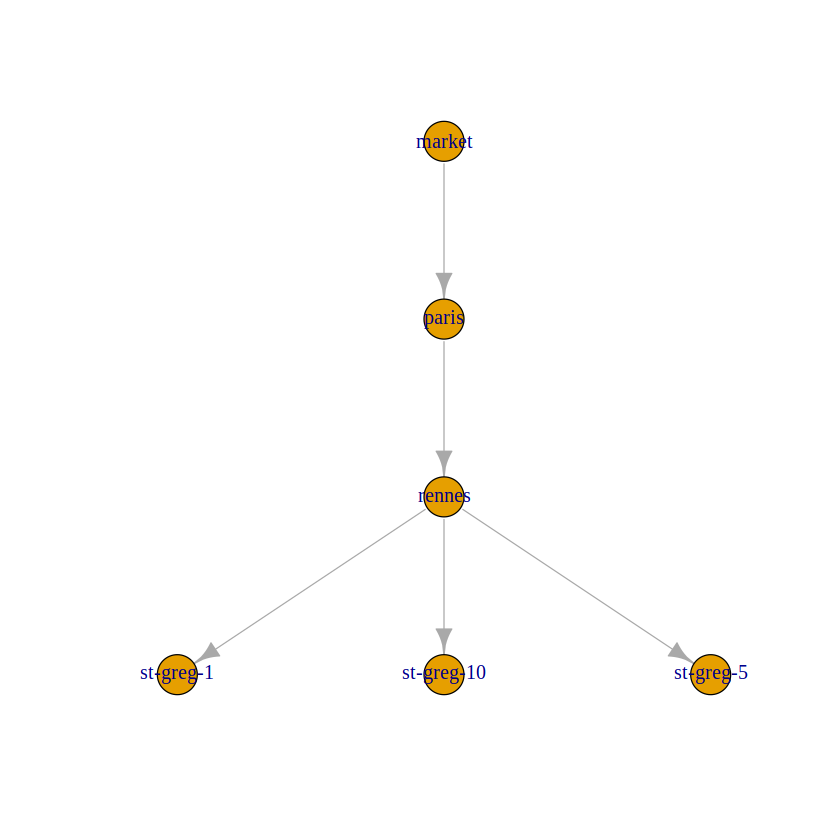

In [34]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

## Data preprocessing

In [35]:
names_raw <- read.csv2(file = paste(METRICS_PATH, "names.csv", sep = "/"), header = TRUE, sep = "\t")
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [36]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp_raw = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp_raw, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [37]:
mem <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  select(c(instance, value)) %>%
  mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
  mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  select(c(instance, value)) %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  group_by(instance) %>%
  mutate(value = as.numeric(as.character(value)))

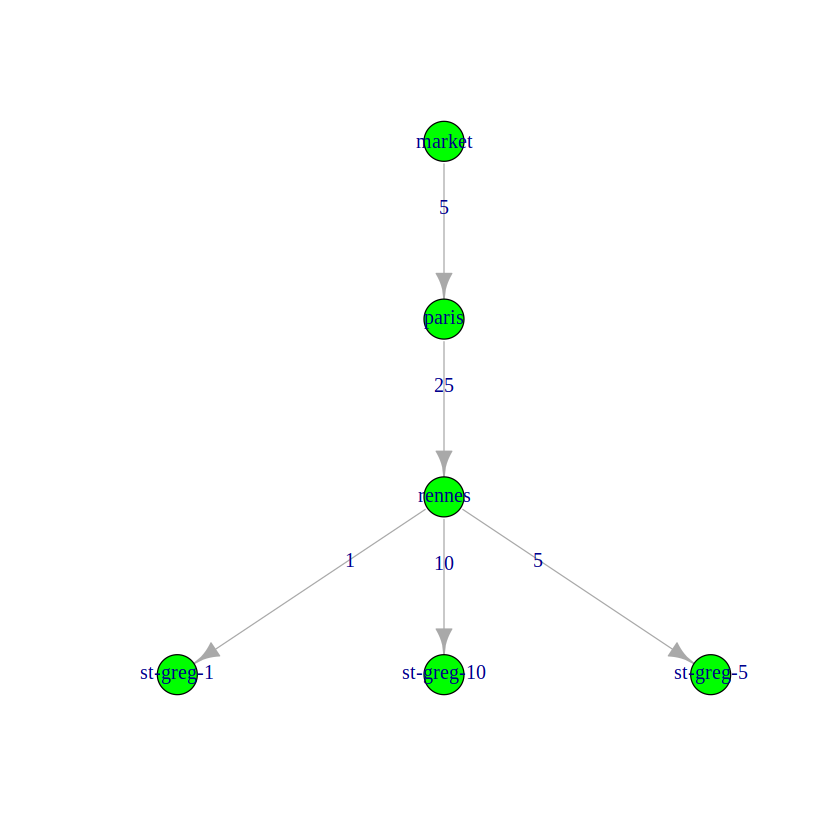

In [38]:
PercentageColourConnected <- function(x) {
  colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

In [39]:
bids_raw <- read.csv2(file = paste(METRICS_PATH, "fog_node_bids.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare()

head(bids_raw)

instance name          bid_id                              
1 market   fog_node_bids b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd
2 market   fog_node_bids b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd
3 market   fog_node_bids b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd
4 market   fog_node_bids b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd
5 market   fog_node_bids d21e74d0-4058-4fd8-9fb0-4660ff30095c
6 market   fog_node_bids b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd
  function_name       job      timestamp           value        timestamp_raw n
1 echo-040-500-25-100 telegraf 2023-01-05 13:01:36 0.0009332178 1672923696    0
2 echo-040-500-25-100 telegraf 2023-01-05 13:02:26 0.0009332178 1672923746    0
3 echo-040-500-25-100 telegraf 2023-01-05 13:01:06 0.0009332178 1672923666    0
4 echo-040-500-25-100 telegraf 2023-01-05 13:02:16 0.0009332178 1672923736    0
5 echo-032-500-25-100 telegraf 2023-01-05 13:00:26 0.0009125714 1672923626    0
6 echo-040-500-25-100 telegraf 2023-01-05 13:02:06 0.0009332178 1672923726    0

instance  n 
1 market    25
2 rennes    13
3 st-greg-5 12

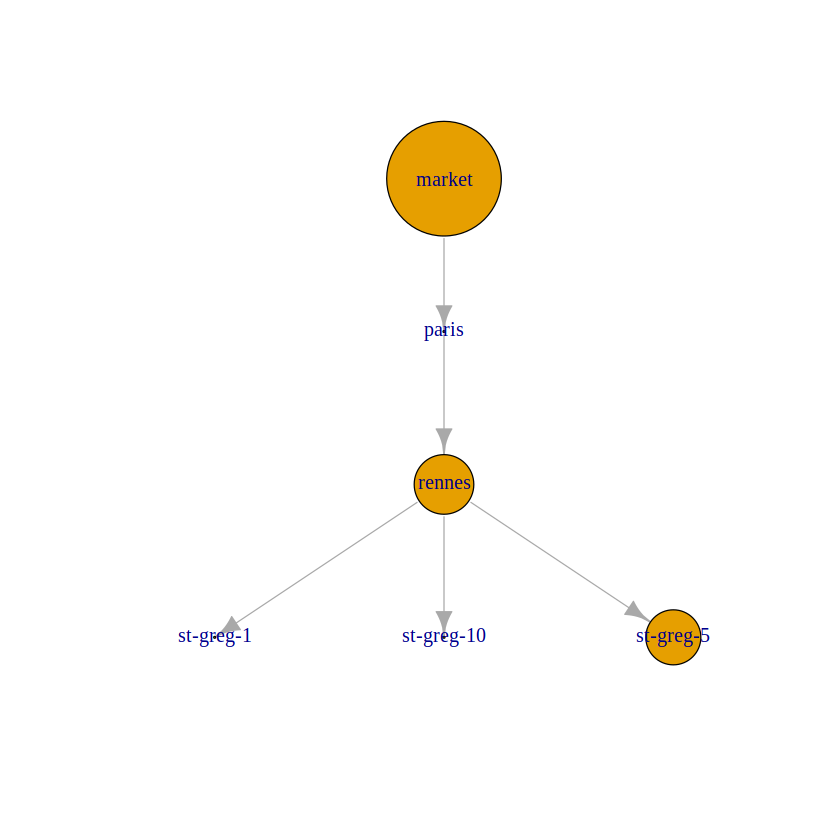

In [40]:
bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange()

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)

Plot the free cpu

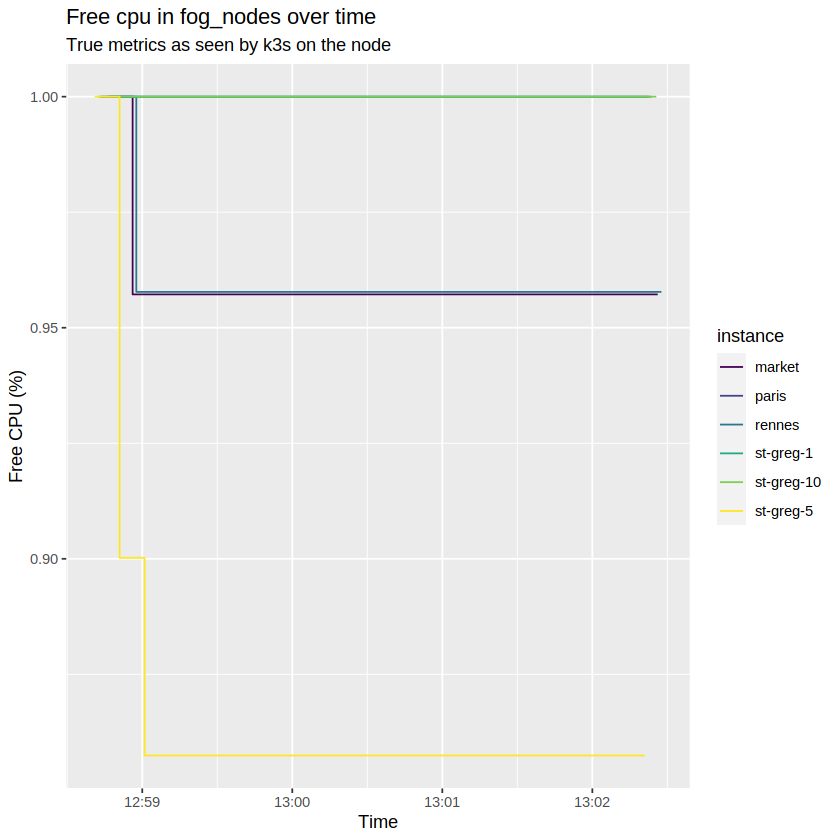

In [41]:
cpu_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
cpu_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

cpu_free %>%
ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free CPU (%)", title = "Free cpu in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

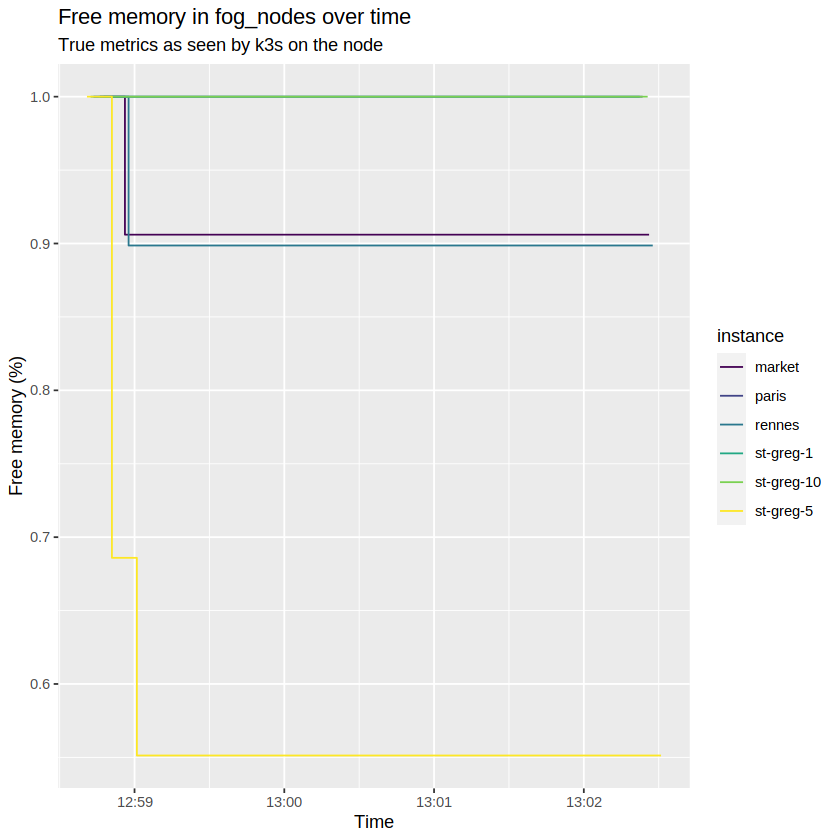

In [42]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

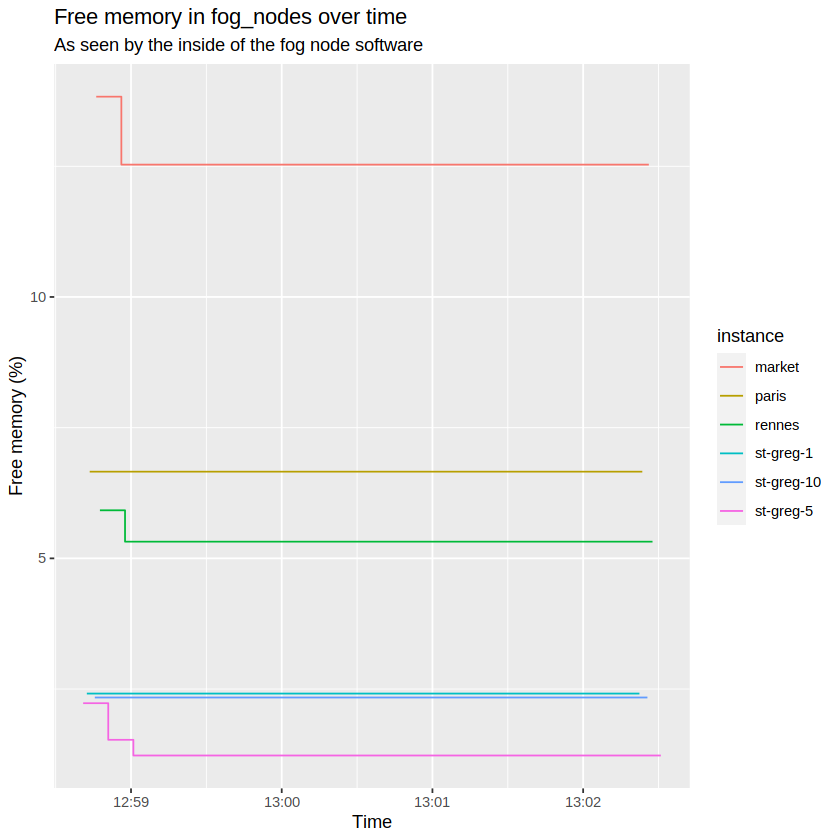

In [43]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "As seen by the inside of the fog node software")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


instance   instance_to mean_ms
1  market     paris        11    
2  paris      market      637    
3  paris      rennes       51    
4  rennes     paris        51    
5  rennes     st-greg-1     3    
6  rennes     st-greg-10   21    
7  rennes     st-greg-5    11    
8  st-greg-1  rennes      520    
9  st-greg-10 rennes       21    
10 st-greg-5  rennes      511

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


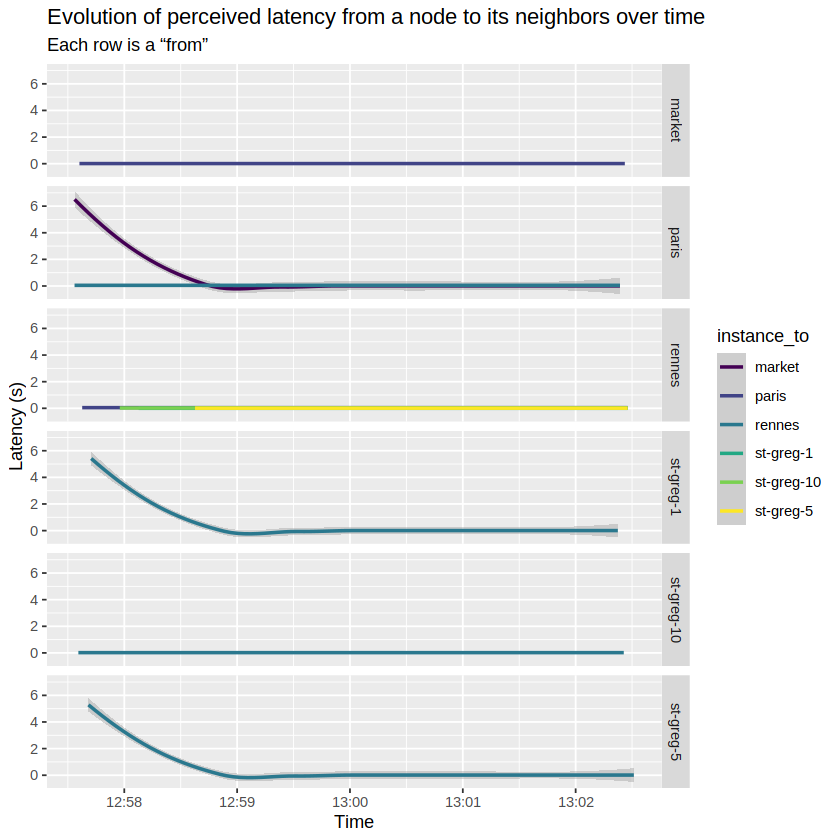

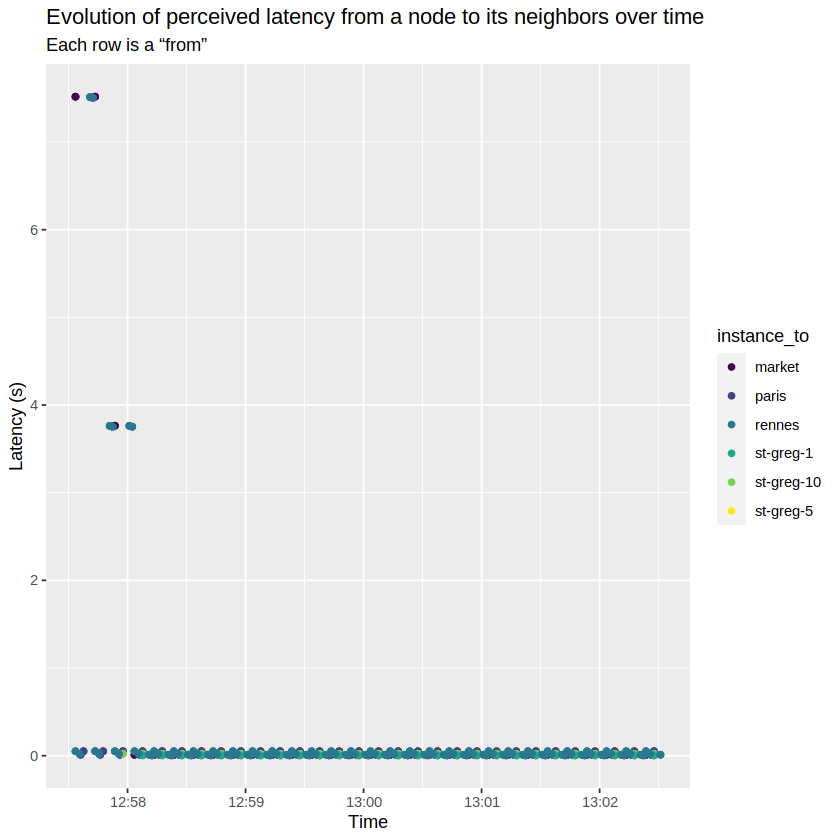

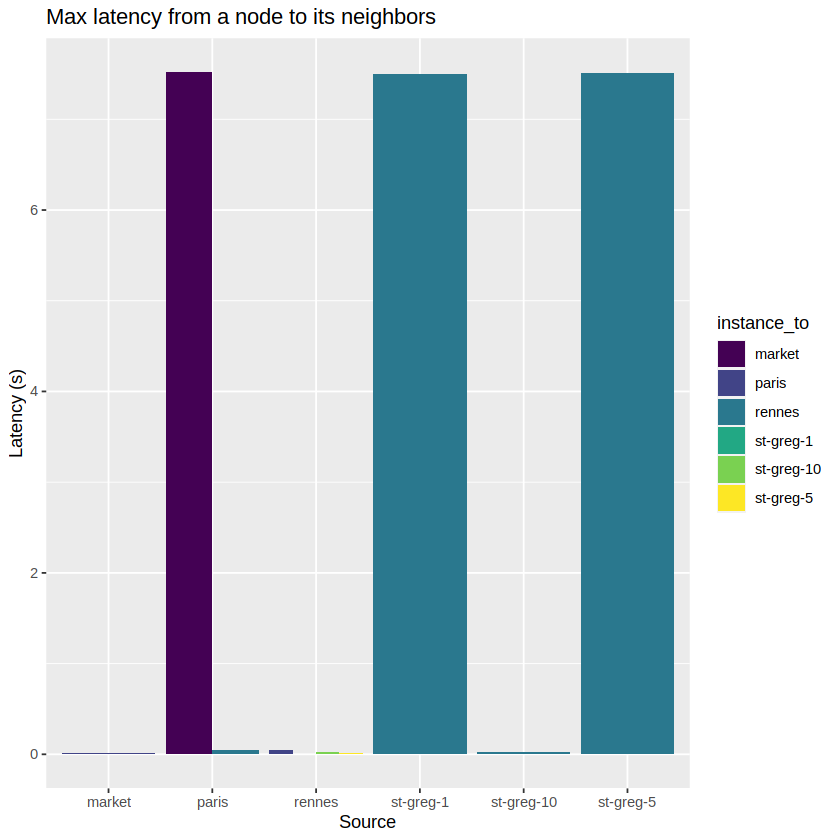

In [44]:
latency <- read.csv2(file = paste(METRICS_PATH, "fog_node_neighbors_latency_rolling_avg.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  mutate(instance_to = as.character(names[instance_to]))

latency %>%
  group_by(instance, instance_to) %>%
  summarise(mean_ms = round(mean(value * 1000), 0))

latency %>%
  ggplot(aes(x = timestamp, y = value, color = instance_to)) +
geom_smooth() +
  labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
  facet_grid(rows = vars(instance))+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

latency %>%
  ggplot(aes(x = timestamp, y = value, color = instance_to)) +
geom_point() +
  labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

latency %>% group_by(instance, instance_to) %>% mutate(max = max(value)) %>% select(instance, instance_to, max) %>% 
  ggplot(aes(x = instance, y = max, fill = instance_to)) +
geom_col(position="dodge") +
  labs(x = "Source", y = "Latency (s)", title = "Max latency from a node to its neighbors") +
  # facet_grid(rows = vars(instance_to))+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

In [45]:
iot_request_duration <- read.csv2(file = paste(METRICS_PATH, "iot_emulation_http_request_duration_seconds_print_bucket.csv", sep = ""), header = TRUE, sep = "\t") %>%
  prepare() %>%
  select(instance, tag, value, le, n)

head(iot_request_duration)

instance tag                 value le   n 
1 market   NA                  NA    NA    0
2 NULL     echo-001-100-25-100  1    +Inf NA
3 NULL     echo-001-100-25-100  3    +Inf NA
4 NULL     echo-001-100-25-100  5    +Inf NA
5 NULL     echo-001-100-25-100  7    +Inf NA
6 NULL     echo-001-100-25-100  9    +Inf NA

instance  name          bid_id                              
1 market    fog_node_bids 04950b9f-468e-4d1e-8eab-64f1bde2b77f
2 rennes    fog_node_bids 8f63349a-54d2-44c0-96a9-7aa5a1e35ca4
3 st-greg-5 fog_node_bids 57c5acf1-0789-489e-a504-c844ef788856
4 market    fog_node_bids 41143238-618a-460e-9d2e-ef999ffbef3d
5 market    fog_node_bids 971ced48-aca9-4b20-8c5e-d7a8b62e3312
6 rennes    fog_node_bids 2ef19fbd-1691-41e3-90e3-b013a9ff13c0
  function_name       job      timestamp           value        timestamp_raw n
1 echo-001-100-25-100 telegraf 2023-01-05 13:01:16 0.0008435242 1672923676    0
2 echo-002-50-25-100  telegraf 2023-01-05 12:58:47 0.0040835514 1672923528    0
3 echo-003-10-25-100  telegraf 2023-01-05 13:01:30 0.0246375735 1672923691    0
4 echo-004-500-25-100 telegraf 2023-01-05 13:02:16 0.0008477614 1672923736    0
5 echo-005-100-25-100 telegraf 2023-01-05 13:00:56 0.0008520468 1672923656    0
6 echo-006-50-25-100  telegraf 2023-01-05 13:00:27 0.0041307304 1672923628    0
  winner   
1 market   
2 rennes   
3 st-greg-5
4 market   
5 market   
6 rennes

instance.x function_name       value.x      latency instance.y name         
1 market     echo-040-500-25-100 0.0009332178 500     market     fog_node_bids
2 market     echo-032-500-25-100 0.0009125714 500     market     fog_node_bids
3 market     echo-036-500-25-100 0.0009227633 500     market     fog_node_bids
4 market     echo-016-500-25-100 0.0008742267 500     market     fog_node_bids
5 market     echo-008-500-25-100 0.0008563811 500     market     fog_node_bids
6 market     echo-012-500-25-100 0.0008652003 500     market     fog_node_bids
  bid_id                               job      timestamp          
1 b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd telegraf 2023-01-05 13:01:36
2 d21e74d0-4058-4fd8-9fb0-4660ff30095c telegraf 2023-01-05 13:00:26
3 2eea09df-7688-438d-ab54-e6db93351dd0 telegraf 2023-01-05 12:59:16
4 95b54c33-fdec-40de-bd9c-e97936e58f2a telegraf 2023-01-05 13:00:26
5 529cadc0-414a-458b-a41f-34fc427aec6f telegraf 2023-01-05 12:59:56
6 97918e66-2d2f-43ea-8f62-9d376b8e8e1f telegraf 2023-01-05 13:00:06
  value.y      timestamp_raw n winner
1 0.0009332178 1672923696    0 market
2 0.0009125714 1672923626    0 market
3 0.0009227633 1672923556    0 market
4 0.0008742267 1672923626    0 market
5 0.0008563811 1672923596    0 market
6 0.0008652003 1672923606    0 market

Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


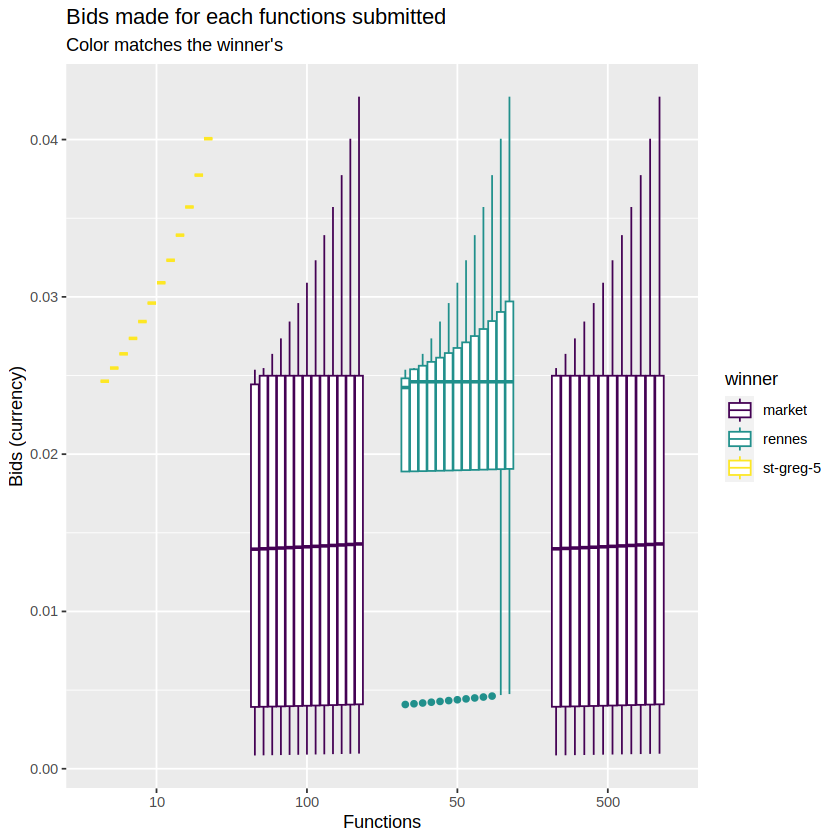

In [46]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

head(bids_won_function)

bids_function <- bids_raw %>%
  select(c(instance, function_name, value)) %>%
  distinct() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  inner_join(bids_won_function, by = c("function_name"))

head(bids_function)

bids_function %>%
  ggplot(aes(x = latency, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  # geom_point() +
  # geom_text(hjust = 0, vjust = 0) +
  labs(x = "Functions", y = "Bids (currency)", title = "Bids made for each functions submitted", subtitle = "Color matches the winner's")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


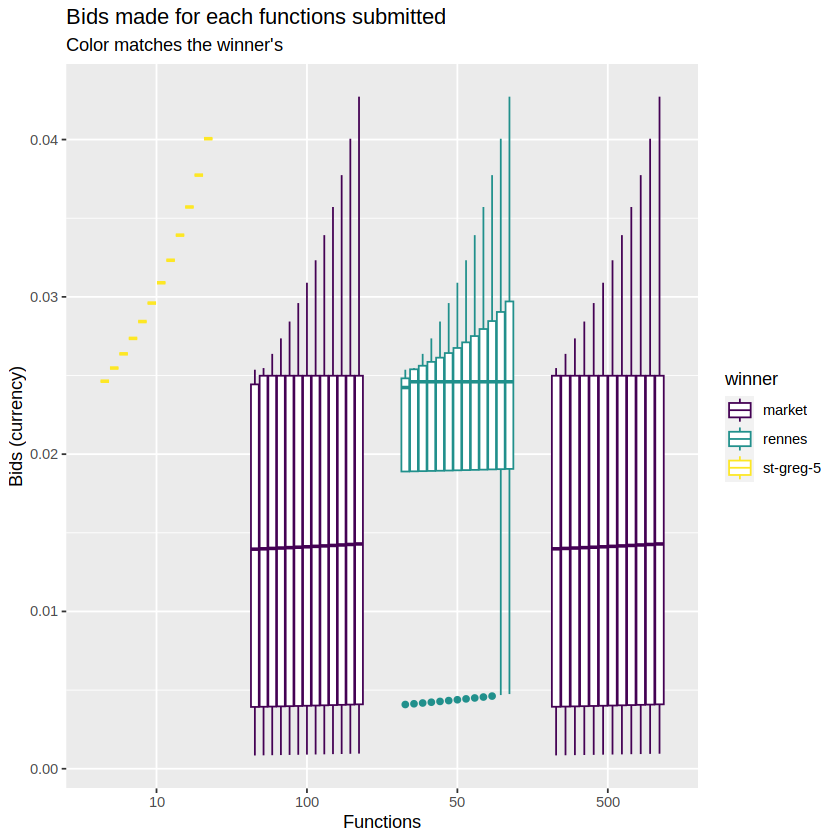

In [47]:
bids_function %>%
  ggplot(aes(x = latency, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  # geom_point() +
  # geom_text(hjust = 0, vjust = 0) +
  labs(x = "Functions", y = "Bids (currency)", title = "Bids made for each functions submitted", subtitle = "Color matches the winner's")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

winner    function_name       value       
1 market    echo-001-100-25-100 0.0008435242
2 rennes    echo-002-50-25-100  0.0040835514
3 st-greg-5 echo-003-10-25-100  0.0246375735
4 market    echo-004-500-25-100 0.0008477614
5 market    echo-005-100-25-100 0.0008520468
6 rennes    echo-006-50-25-100  0.0041307304

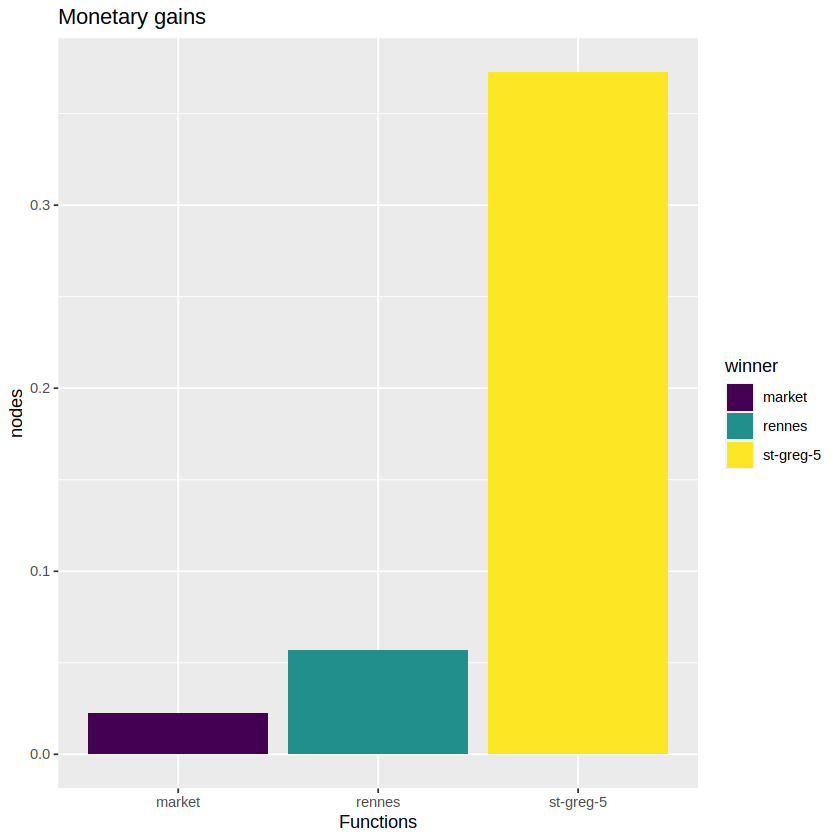

In [48]:
winner_gains <- bids_won_function %>%
  select(c(winner, function_name, value)) %>%
  distinct()
head(winner_gains)

winner_gains %>%
  ggplot(aes(x = winner, y = value, fill = winner)) +
  geom_col() +
  labs(x = "Functions", y = "nodes", title = "Monetary gains")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

instance.x function_name       value.x      latency instance.y name         
1 market     echo-040-500-25-100 0.0009332178 500     market     fog_node_bids
2 market     echo-032-500-25-100 0.0009125714 500     market     fog_node_bids
3 market     echo-036-500-25-100 0.0009227633 500     market     fog_node_bids
4 market     echo-016-500-25-100 0.0008742267 500     market     fog_node_bids
5 market     echo-008-500-25-100 0.0008563811 500     market     fog_node_bids
6 market     echo-012-500-25-100 0.0008652003 500     market     fog_node_bids
  bid_id                               job      timestamp          
1 b6e9ffda-6d0e-42f5-9cb3-b58a7a7f3afd telegraf 2023-01-05 13:01:36
2 d21e74d0-4058-4fd8-9fb0-4660ff30095c telegraf 2023-01-05 13:00:26
3 2eea09df-7688-438d-ab54-e6db93351dd0 telegraf 2023-01-05 12:59:16
4 95b54c33-fdec-40de-bd9c-e97936e58f2a telegraf 2023-01-05 13:00:26
5 529cadc0-414a-458b-a41f-34fc427aec6f telegraf 2023-01-05 12:59:56
6 97918e66-2d2f-43ea-8f62-9d376b8e8e1f telegraf 2023-01-05 13:00:06
  value.y      timestamp_raw n winner
1 0.0009332178 1672923696    0 market
2 0.0009125714 1672923626    0 market
3 0.0009227633 1672923556    0 market
4 0.0008742267 1672923626    0 market
5 0.0008563811 1672923596    0 market
6 0.0008652003 1672923606    0 market

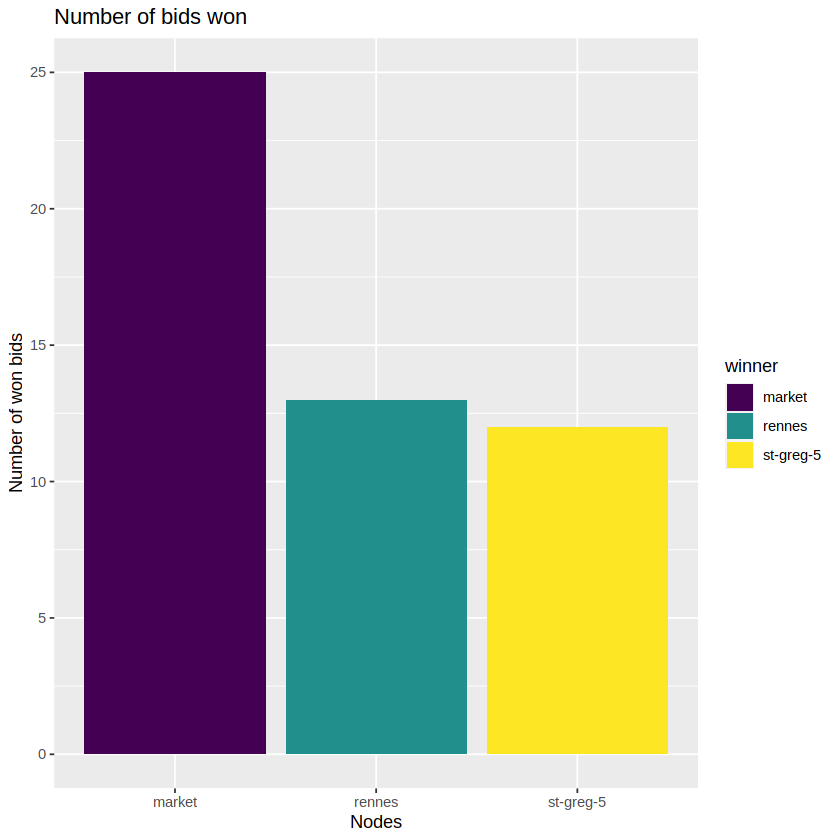

In [49]:
head(bids_function)

bids_function %>%
  select(winner, function_name) %>%
  distinct() %>%
  ggplot(aes(x = winner, fill = winner)) +
  geom_bar() +
  labs(x = "Nodes", y = "Number of won bids", title = "Number of bids won")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

`summarise()` has grouped output by 'winner', 'timestamp'. You can override using the `.groups` argument.


[1] "100"


Adding missing grouping variables: `tag`


# A tibble: 13 × 2
# Groups:   tag [13]
   tag                 function_name      
   <chr>               <chr>              
 1 echo-001-100-25-100 echo-001-100-25-100
 2 echo-005-100-25-100 echo-005-100-25-100
 3 echo-009-100-25-100 echo-009-100-25-100
 4 echo-013-100-25-100 echo-013-100-25-100
 5 echo-017-100-25-100 echo-017-100-25-100
 6 echo-021-100-25-100 echo-021-100-25-100
 7 echo-025-100-25-100 echo-025-100-25-100
 8 echo-029-100-25-100 echo-029-100-25-100
 9 echo-033-100-25-100 echo-033-100-25-100
10 echo-037-100-25-100 echo-037-100-25-100
11 echo-041-100-25-100 echo-041-100-25-100
12 echo-045-100-25-100 echo-045-100-25-100
13 echo-049-100-25-100 echo-049-100-25-100


Warning message:
“Removed 11454 rows containing missing values (`geom_point()`).”


[1] "50"


Adding missing grouping variables: `tag`


# A tibble: 13 × 2
# Groups:   tag [13]
   tag                function_name     
   <chr>              <chr>             
 1 echo-002-50-25-100 echo-002-50-25-100
 2 echo-006-50-25-100 echo-006-50-25-100
 3 echo-010-50-25-100 echo-010-50-25-100
 4 echo-014-50-25-100 echo-014-50-25-100
 5 echo-018-50-25-100 echo-018-50-25-100
 6 echo-022-50-25-100 echo-022-50-25-100
 7 echo-026-50-25-100 echo-026-50-25-100
 8 echo-030-50-25-100 echo-030-50-25-100
 9 echo-034-50-25-100 echo-034-50-25-100
10 echo-038-50-25-100 echo-038-50-25-100
11 echo-042-50-25-100 echo-042-50-25-100
12 echo-046-50-25-100 echo-046-50-25-100
13 echo-050-50-25-100 echo-050-50-25-100


Warning message:
“Removed 7636 rows containing missing values (`geom_point()`).”


[1] "10"


Adding missing grouping variables: `tag`


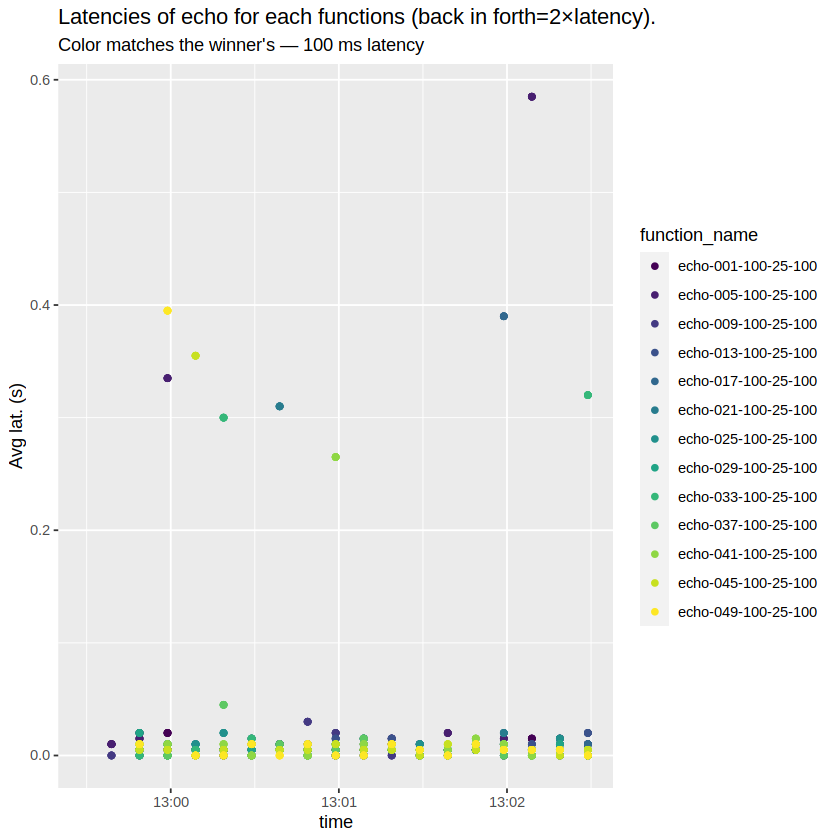

# A tibble: 12 × 2
# Groups:   tag [12]
   tag                function_name     
   <chr>              <chr>             
 1 echo-003-10-25-100 echo-003-10-25-100
 2 echo-007-10-25-100 echo-007-10-25-100
 3 echo-011-10-25-100 echo-011-10-25-100
 4 echo-015-10-25-100 echo-015-10-25-100
 5 echo-019-10-25-100 echo-019-10-25-100
 6 echo-023-10-25-100 echo-023-10-25-100
 7 echo-027-10-25-100 echo-027-10-25-100
 8 echo-031-10-25-100 echo-031-10-25-100
 9 echo-035-10-25-100 echo-035-10-25-100
10 echo-039-10-25-100 echo-039-10-25-100
11 echo-043-10-25-100 echo-043-10-25-100
12 echo-047-10-25-100 echo-047-10-25-100


Warning message:
“Removed 1756 rows containing missing values (`geom_point()`).”


[1] "500"


Adding missing grouping variables: `tag`


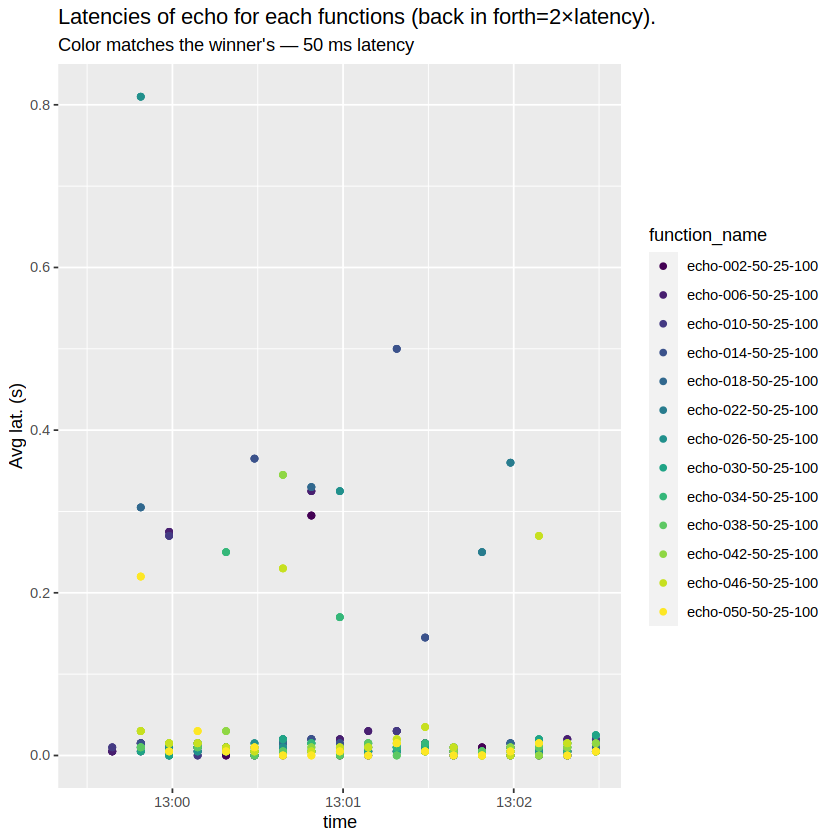

# A tibble: 12 × 2
# Groups:   tag [12]
   tag                 function_name      
   <chr>               <chr>              
 1 echo-004-500-25-100 echo-004-500-25-100
 2 echo-008-500-25-100 echo-008-500-25-100
 3 echo-012-500-25-100 echo-012-500-25-100
 4 echo-016-500-25-100 echo-016-500-25-100
 5 echo-020-500-25-100 echo-020-500-25-100
 6 echo-024-500-25-100 echo-024-500-25-100
 7 echo-028-500-25-100 echo-028-500-25-100
 8 echo-032-500-25-100 echo-032-500-25-100
 9 echo-036-500-25-100 echo-036-500-25-100
10 echo-040-500-25-100 echo-040-500-25-100
11 echo-044-500-25-100 echo-044-500-25-100
12 echo-048-500-25-100 echo-048-500-25-100


Warning message:
“Removed 10536 rows containing missing values (`geom_point()`).”


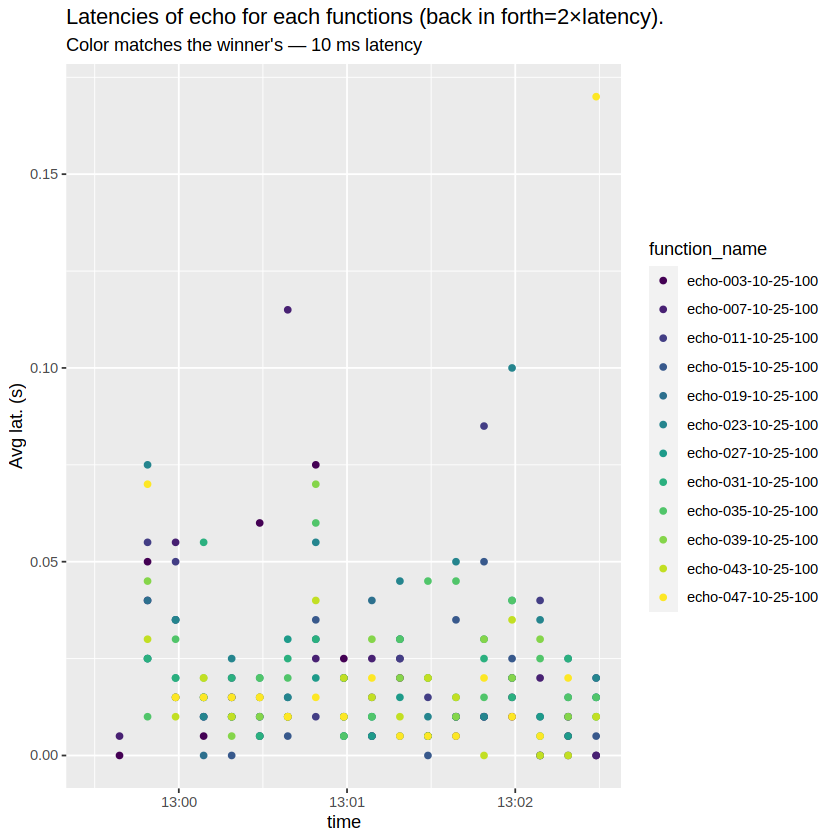

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


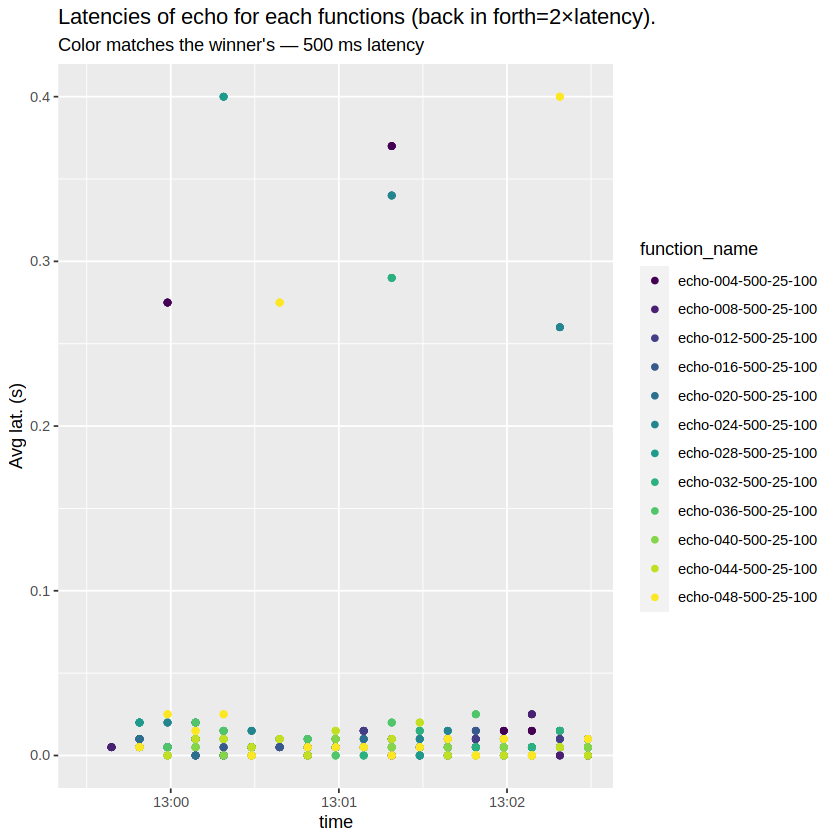

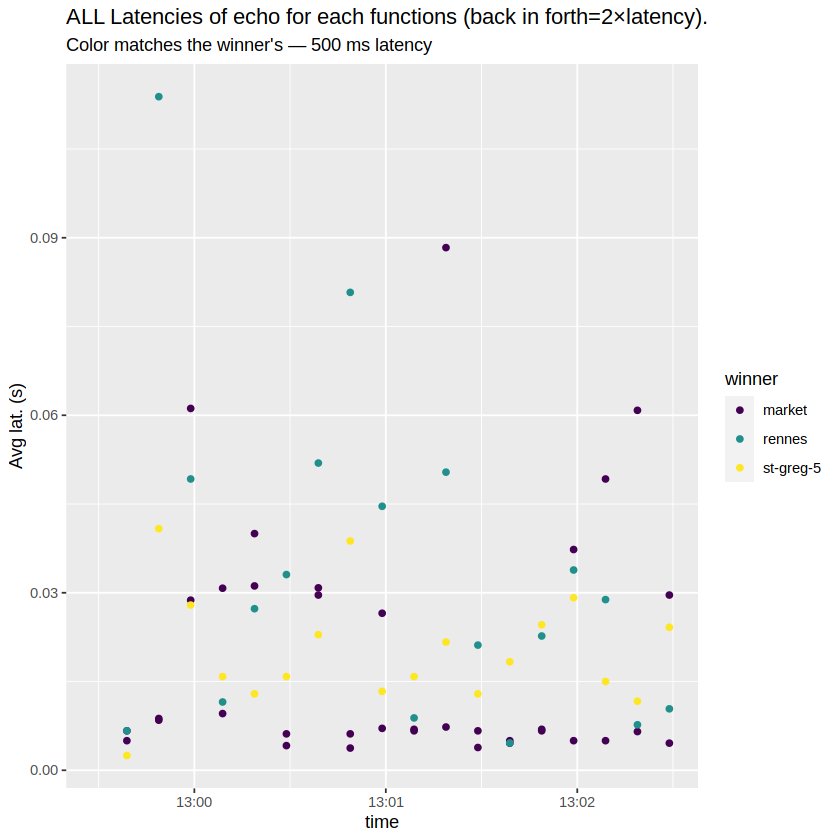

In [50]:
toto <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_sum.csv", header = TRUE, sep = "\t") %>%
  prepare()

titi <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_count.csv", header = TRUE, sep = "\t") %>%
  prepare()


latencies <- toto %>%
  mutate(latency = stringr::str_match(tag, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  select(latency) %>%
  distinct() %>%
  filter(!is.na(latency))

tutu <- toto %>%
  inner_join(titi,
             by = c("instance", "job", "timestamp", "timestamp_raw", "tag"),
  ) %>%
  group_by(tag) %>%
  mutate(new_x = value.x - dplyr::lag(x = value.x, n = 1,
                                      order_by = timestamp)) %>%
  mutate(new_y = value.y - dplyr::lag(x = value.y, n = 1,
                   
                   order_by = timestamp)) %>%
  mutate(new_avg = new_x / new_y) %>%
  mutate(function_name = tag) %>%
  mutate(latency = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  mutate(index = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 3]) %>%
  inner_join(bids_function %>% select(function_name, winner),
             by = c("function_name"))

tata <- tutu %>%
  group_by(winner, timestamp, latency) %>%
  summarise(avg = mean(new_avg, na.rm = TRUE))

for (selected_latency in latencies$latency)
{
  print(selected_latency)
  
  
  print(
    tutu %>% filter(latency == selected_latency) %>%
      select(function_name) %>%
      distinct()
  )
  
  
  # print(
  #   tutu %>% filter(latency == selected_latency) %>% 
  #     group_by(tag) %>%
  #     mutate(count = max(value.y)) %>%
  #     select(index, winner, count, latency) %>%
  #     distinct() %>%
  #     ggplot(
  #       aes(
  #         x = index,
  #         y = count,
  #         group = index,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_col() +
  #     labs(
  #       x = "Function id",
  #       y = "Number of echo requests",
  #       title = "Number of requests made to each functions (back in forth=2×latency)",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
  
  # print(
  #   tutu %>% 
  #     filter(latency == selected_latency) %>%
  #     ggplot(
  #       aes(
  #         x = winner,
  #         y = new_avg,
  #         group = winner,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_violin() +
  #     labs(
  #       x = "time",
  #       y = "Avg lat. (s)",
  #       title = "Latencies of echo for each functions (back in forth=2×latency).",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
  
  print(
    tutu %>%
      filter(latency == selected_latency) %>%
      group_by(function_name) %>%
      ggplot(
        aes(
          x = timestamp,
          y = new_avg,
          group = index,
          color = function_name,
          label = latency
        )
      ) +
      geom_point() +
      labs(
        x = "time",
        y = "Avg lat. (s)",
        title = "Latencies of echo for each functions (back in forth=2×latency).",
        subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
      ) +
      scale_color_viridis(discrete = TRUE, option = "D") +
      scale_fill_viridis(discrete = TRUE)
  )
  
  # print(
  #   tata %>%
  #     filter(latency == selected_latency) %>%
  #     group_by(winner) %>%
  #     ggplot(
  #       aes(
  #         x = timestamp,
  #         y = avg,
  #         group = winner,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_point() +
  #     labs(
  #       x = "time",
  #       y = "Avg lat. (s)",
  #       title = "Latencies of echo for each functions (back in forth=2×latency).",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
}
print(
  tata %>%
    group_by(winner) %>%
    ggplot(
      aes(
        x = timestamp,
        y = avg,
        group = winner,
        color = winner,
        # label = latency
      )
    ) +
    geom_point() +
    labs(
      x = "time",
      y = "Avg lat. (s)",
      title = "ALL Latencies of echo for each functions (back in forth=2×latency).",
      subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
    ) +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)